In [37]:
import os
import joblib
import numpy as np 
import pandas as pd 
from math import log10

from rdkit import Chem 
from rdkit.Chem import AllChem, rdMolDescriptors, DataStructs, rdChemReactions
from rdkit.Chem.AtomPairs import Pairs

from map4 import MAP4Calculator
from mhfp.encoder import MHFPEncoder
from mxfp.mxfp import MXFPCalculator
from drfp import DrfpEncoder
from rxnmapper import RXNMapper

import tmap as tm 
from faerun import Faerun
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy import stats

from tqdm import tqdm
tqdm.pandas()
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)

sns.set(font_scale=2.5)
sns.set_style('ticks')
sns.despine()

<Figure size 640x480 with 0 Axes>

#### Data pre-processing

Import data set, kekulize SMILES, remove stereochemistry and remove duplicates. Correct faulty tautomerization

In [38]:
df = pd.read_csv('data/zinc_fda.csv')

df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)
rxn = rdChemReactions.ReactionFromSmarts('[N:1]=[C:2][OH:3]>>[N:1][C:2]=[O:3]') # Define tautomerization reaction from iminol to amide
df['mol'].apply(lambda x: rxn.RunReactantInPlace(x)) # Apply tautomerization
df['isomeric_smiles'] = df['mol'].apply(lambda x: Chem.MolToSmiles(x, isomericSmiles=True, kekuleSmiles=True))
df['smiles'] = df['mol'].apply(lambda x: Chem.MolToSmiles(x, isomericSmiles=False, kekuleSmiles=True))
df = df.drop_duplicates(subset=['smiles'])

Add molecular properties

In [39]:
df['molecular_weight'] = df['mol'].apply(rdMolDescriptors.CalcExactMolWt)
df['fraction_csp3'] = df['mol'].apply(lambda x: rdMolDescriptors.CalcFractionCSP3(x))
df['heavy_atom_count'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())
df['fraction_c'] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmarts('[#6]')))/(x.GetNumHeavyAtoms()))
df['fraction_n'] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmarts('[#7]')))/(x.GetNumHeavyAtoms()))
df['fraction_o'] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmarts('[#8]')))/(x.GetNumHeavyAtoms()))
df['fraction_s'] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmarts('[#16]')))/(x.GetNumHeavyAtoms()))
df['fraction_halogen'] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmarts('[#9,#17,#35,#53]')))/(x.GetNumHeavyAtoms()))
df['fraction_hba'] = df['mol'].apply(lambda x: rdMolDescriptors.CalcNumLipinskiHBA(x)/(x.GetNumHeavyAtoms()))
df['fraction_hbd'] = df['mol'].apply(lambda x: rdMolDescriptors.CalcNumLipinskiHBD(x)/(x.GetNumHeavyAtoms()))
df['ring_count'] = df['mol'].apply(lambda x: len(x.GetRingInfo().AtomRings()))
df['clogp'] = df['mol'].apply(lambda x: rdMolDescriptors.CalcCrippenDescriptors(x)[0])

Sort data frame by heavy atom count. When generating the molecular pairs, we want to start with the smallest molecules first.

In [40]:
df = df.sort_values(by='heavy_atom_count', ascending=True)

#### Calculate molecular descriptors

Calculate ECFP4, ECFP6, MHFP6, AP, MXFP, MAP4, MACCS and MQN descriptors

In [41]:
map4 = MAP4Calculator(dimensions=2048)
mhfp6 = MHFPEncoder(n_permutations=2048)
mxfp = MXFPCalculator(dimensionality='2D')

df['ecfp4'] = df['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=2048))
df['ecfp6'] = df['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 3, nBits=2048))
df['mhfp6'] = df['smiles'].apply(mhfp6.encode)
df['ap'] = df['mol'].apply(Pairs.GetAtomPairFingerprintAsBitVect)
df['mxfp'] = df['mol'].apply(mxfp.mxfp_from_mol)
df['map4'] = df['mol'].apply(map4.calculate)
df['maccs'] = df['mol'].apply(AllChem.GetMACCSKeysFingerprint)
df['mqn'] = df['mol'].apply(rdMolDescriptors.MQNs_)

#### Calculate pairwise distances

Define distance metrics and calculate distance matrices

In [42]:
enc = tm.Minhash(2048)

def jaccard(a, b):
    return enc.get_distance(a, b)

def mhfp6(a, b):
    return 1.0 - float(np.count_nonzero(a == b)) / float(len(a))

def manhattan(a, b):
    return sum(abs(np.array(a) - np.array(b)))

def tanimoto(a, b):
    return 1.0 - DataStructs.FingerprintSimilarity(a, b)

def pairwise_distances(fps, metric):
    return pd.DataFrame([[metric(fps[i], fps[j]) for j in range(len(fps))] for i in range(len(fps))])

ecfp4_dist = pairwise_distances(df['ecfp4'].values, tanimoto)
ecfp6_dist = pairwise_distances(df['ecfp6'].values, tanimoto)
mhfp6_dist = pairwise_distances(df['mhfp6'].values, mhfp6)
ap_dist = pairwise_distances(df['ap'].values, tanimoto)
mxfp_dist = pairwise_distances(df['mxfp'].values, manhattan)
map4_dist = pairwise_distances(df['map4'].values, jaccard)
maccs_dist = pairwise_distances(df['maccs'].values, tanimoto)
mqn_dist = pairwise_distances(df['mqn'].values, manhattan)

MinMax normalization of MXFP and MQNs

In [43]:
def MinMax(matrix):
    return (matrix-np.min(matrix))/(np.max(matrix)-np.min(matrix)) # Preserves the underlying distribution

mxfp_dist = MinMax(mxfp_dist)
mqn_dist = MinMax(mqn_dist)

Combine distance matrices into one data frame

In [44]:
ecfp4_dist_flat = ecfp4_dist.values.flatten()
ecfp6_dist_flat = ecfp6_dist.values.flatten()
mhfp6_dist_flat = mhfp6_dist.values.flatten()
ap_dist_flat = ap_dist.values.flatten()
mxfp_dist_flat = mxfp_dist.values.flatten()
map4_dist_flat = map4_dist.values.flatten()
maccs_dist_flat = maccs_dist.values.flatten()
mqn_dist_flat = mqn_dist.values.flatten()

df_dist = pd.DataFrame({'ecfp4': ecfp4_dist_flat, 'ecfp6': ecfp6_dist_flat, 'mhfp6': mhfp6_dist_flat, 'ap': ap_dist_flat, 'mxfp': mxfp_dist_flat, 'map4': map4_dist_flat, 'maccs': maccs_dist_flat, 'mqn': mqn_dist_flat})
df_dist = df_dist.stack().reset_index()
df_dist.columns = ['index', 'fingerprint', 'distance']

Rank data

In [45]:
ecfp4_ranked = ecfp4_dist.rank(method='average')
ecfp6_ranked = ecfp6_dist.rank(method='average')
mhfp6_ranked = mhfp6_dist.rank(method='average')
ap_ranked = ap_dist.rank(method='average')
mxfp_ranked = mxfp_dist.rank(method='average')
map4_ranked = map4_dist.rank(method='average')
maccs_ranked = maccs_dist.rank(method='average')
mqn_ranked = mqn_dist.rank(method='average')

#### Pairs selection

Generate relational properties

In [46]:
def empty_string_matrix(length):
    empty_string_matrix = []
    for i in range(length):
        empty_string_list = []
        for j in range(length):
            empty_string_list.append('')
        empty_string_matrix.append(empty_string_list)
    return empty_string_matrix

def reaction_smiles(smiles_list):
    pwrs = empty_string_matrix(len(smiles_list))
    for i in range(len(smiles_list)):
        for j in range(i, len(smiles_list)):
            pwrs[i][j] = f'{smiles_list[i]}>>{smiles_list[j]}'
            pwrs[j][i] = f'{smiles_list[i]}>>{smiles_list[j]}'
    return pwrs

def calculate_mu(values_list):
    matrix = []
    for i in range(len(values_list)):
        row = []
        for j in range(len(values_list)):
            row.append((values_list[i] + values_list[j])/2)
        matrix.append(row)
    return matrix

def calculate_delta(values_list):
    matrix = []
    for i in range(len(values_list)):
        row = []
        for j in range(len(values_list)):
            row.append(abs(values_list[i] - values_list[j]))
        matrix.append(row)
    return matrix

reaction_smiles = reaction_smiles(df['isomeric_smiles'].values.tolist())
mu_molecular_weight = calculate_mu(df['molecular_weight'].values.tolist())
mu_fraction_csp3 = calculate_mu(df['fraction_csp3'].values.tolist())
mu_heavy_atom_count = calculate_mu(df['heavy_atom_count'].values.tolist())
mu_fraction_c = calculate_mu(df['fraction_c'].values.tolist())
mu_fraction_n = calculate_mu(df['fraction_n'].values.tolist())
mu_fraction_o = calculate_mu(df['fraction_o'].values.tolist())
mu_fraction_s = calculate_mu(df['fraction_s'].values.tolist())
mu_fraction_halogen = calculate_mu(df['fraction_halogen'].values.tolist())
mu_fraction_hba = calculate_mu(df['fraction_hba'].values.tolist())
mu_fraction_hbd = calculate_mu(df['fraction_hbd'].values.tolist())
mu_ring_count = calculate_mu(df['ring_count'].values.tolist())
mu_clogp = calculate_mu(df['clogp'].values.tolist())

Determine indices of pairs within the chosen distance thresholds

In [47]:
def indices_below_threshold(distances, threshold):
    indices = []
    for i in range(len(distances)):
        for j in range(i+1, len(distances)): # exclude self pairs
            if distances[i][j] < threshold: 
                indices.append([i, j])
    return indices

ecfp4_threshold_idxs = indices_below_threshold(ecfp4_dist.values, 0.6)
ecfp6_threshold_idxs = indices_below_threshold(ecfp6_dist.values, 0.6)
mhfp6_threshold_idxs = indices_below_threshold(mhfp6_dist.values, 0.6)
ap_threshold_idxs = indices_below_threshold(ap_dist.values, 0.5)
mxfp_threshold_idxs = indices_below_threshold(mxfp_dist.values, 0.1)
map4_threshold_idxs = indices_below_threshold(map4_dist.values, 0.8)
maccs_threshold_idxs = indices_below_threshold(maccs_dist.values, 0.2)
mqn_threshold_idxs = indices_below_threshold(mqn_dist.values, 0.05)

Determine indices of pairs which contain the top 20 most similar drugs for all drugs in the set

In [48]:
def indices_from_ranks(distances, top_n):
    indices = []
    for i, row in enumerate(distances):
        idxs = row.argsort()
        counter = 0
        length = top_n
        while counter < length:
            if idxs[counter] == i:
                counter += 1
                length += 1
            else:
                indices.append([i, idxs[counter]])
                counter += 1
    return indices

ecfp4_rank_idxs = indices_from_ranks(ecfp4_dist.values, 20)
ecfp6_rank_idxs = indices_from_ranks(ecfp6_dist.values, 20)
mhfp6_rank_idxs = indices_from_ranks(mhfp6_dist.values, 20)
ap_rank_idxs = indices_from_ranks(ap_dist.values, 20)
mxfp_rank_idxs = indices_from_ranks(mxfp_dist.values, 20)
map4_rank_idxs = indices_from_ranks(map4_dist.values, 20)
maccs_rank_idxs = indices_from_ranks(maccs_dist.values, 20)
mqn_rank_idxs = indices_from_ranks(mqn_dist.values, 20)

Determine indices of nearest neighbors for all drugs in the set. This is to ensure that all drugs are represented in the TMAP

In [49]:
ecfp4_nn_idxs = indices_from_ranks(ecfp4_dist.values, 1)
ecfp6_nn_idxs = indices_from_ranks(ecfp6_dist.values, 1)
mhfp6_nn_idxs = indices_from_ranks(mhfp6_dist.values, 1)
ap_nn_idxs = indices_from_ranks(ap_dist.values, 1)
mxfp_nn_idxs = indices_from_ranks(mxfp_dist.values, 1)
map4_nn_idxs = indices_from_ranks(map4_dist.values, 1)
maccs_nn_idxs = indices_from_ranks(maccs_dist.values, 1)
mqn_nn_idxs = indices_from_ranks(mqn_dist.values, 1)

Use the indices to retrieve the reaction SMILES, molecular weight difference and fcsp3 difference. Convert the output to a pandas data frame and concatenated the data frames of each fingerprint.

In [50]:
def value_from_idx(values, idxs):
    return [values[idx[0]][idx[1]] for idx in idxs]

threshold_idxs = [('ecfp4', ecfp4_threshold_idxs), ('ecfp6', ecfp6_threshold_idxs), ('mhfp6', mhfp6_threshold_idxs), ('ap', ap_threshold_idxs), ('mxfp', mxfp_threshold_idxs), ('map4', map4_threshold_idxs), ('maccs', maccs_threshold_idxs), ('mqn', mqn_threshold_idxs) ]

threshold_dfs = []
for name, idxs in threshold_idxs:
    df_iter = pd.DataFrame({
        'reaction_smiles': value_from_idx(reaction_smiles, idxs),
        'mu_molecular_weight': value_from_idx(mu_molecular_weight, idxs),
        'mu_fraction_csp3': value_from_idx(mu_fraction_csp3, idxs),
        'mu_fraction_c': value_from_idx(mu_fraction_c, idxs),
        'mu_fraction_n': value_from_idx(mu_fraction_n, idxs),
        'mu_fraction_o': value_from_idx(mu_fraction_o, idxs),
        'mu_fraction_s': value_from_idx(mu_fraction_s, idxs),
        'mu_fraction_halogen': value_from_idx(mu_fraction_halogen, idxs),
        'mu_fraction_hba': value_from_idx(mu_fraction_hba, idxs),
        'mu_fraction_hbd': value_from_idx(mu_fraction_hbd, idxs),
        'mu_ring_count': value_from_idx(mu_ring_count, idxs),
        'mu_clogp': value_from_idx(mu_clogp, idxs),
        'ecfp4_dist': value_from_idx(ecfp4_dist, idxs),
        'ecfp6_dist': value_from_idx(ecfp6_dist, idxs),
        'mhfp6_dist': value_from_idx(mhfp6_dist, idxs),
        'ap_dist': value_from_idx(ap_dist, idxs),
        'mxfp_dist': value_from_idx(mxfp_dist, idxs),
        'map4_dist': value_from_idx(map4_dist, idxs),
        'maccs_dist': value_from_idx(maccs_dist, idxs),
        'mqn_dist': value_from_idx(mqn_dist, idxs),
        'fp': name
    }).drop_duplicates(subset=['reaction_smiles'])
    threshold_dfs.append(df_iter)

df_threshold_pairs = pd.concat(threshold_dfs, ignore_index=True)
df_threshold_pairs['count'] = df_threshold_pairs.groupby('reaction_smiles')['reaction_smiles'].transform('count') # Drop reaction SMILES duplicates and save the count of occurrences
df_threshold_pairs = df_threshold_pairs.drop_duplicates(subset=['reaction_smiles']).reset_index(drop=True)
df_threshold_pairs['origin'] = 'Distance Threshold'

Same thing as above, but for the ranks indices

In [51]:
rank_idxs = [('ecfp4', ecfp4_rank_idxs), ('ecfp6', ecfp6_rank_idxs), ('mhfp6', mhfp6_rank_idxs), ('ap', ap_rank_idxs), ('mxfp', mxfp_rank_idxs), ('map4', map4_rank_idxs), ('maccs', maccs_rank_idxs), ('mqn', mqn_rank_idxs)]

rank_dfs = []
for name, idxs in rank_idxs:
    df_iter = pd.DataFrame({
        'reaction_smiles': value_from_idx(reaction_smiles, idxs),
        'mu_molecular_weight': value_from_idx(mu_molecular_weight, idxs),
        'mu_fraction_csp3': value_from_idx(mu_fraction_csp3, idxs),
        'mu_fraction_c': value_from_idx(mu_fraction_c, idxs),
        'mu_fraction_n': value_from_idx(mu_fraction_n, idxs),
        'mu_fraction_o': value_from_idx(mu_fraction_o, idxs),
        'mu_fraction_s': value_from_idx(mu_fraction_s, idxs),
        'mu_fraction_halogen': value_from_idx(mu_fraction_halogen, idxs),
        'mu_fraction_hba': value_from_idx(mu_fraction_hba, idxs),
        'mu_fraction_hbd': value_from_idx(mu_fraction_hbd, idxs),
        'mu_ring_count': value_from_idx(mu_ring_count, idxs),
        'mu_clogp': value_from_idx(mu_clogp, idxs),
        'ecfp4_dist': value_from_idx(ecfp4_dist, idxs),
        'ecfp6_dist': value_from_idx(ecfp6_dist, idxs),
        'mhfp6_dist': value_from_idx(mhfp6_dist, idxs),
        'ap_dist': value_from_idx(ap_dist, idxs),
        'mxfp_dist': value_from_idx(mxfp_dist, idxs),
        'map4_dist': value_from_idx(map4_dist, idxs),
        'maccs_dist': value_from_idx(maccs_dist, idxs),
        'mqn_dist': value_from_idx(mqn_dist, idxs),
        'fp': name
    }).drop_duplicates(subset=['reaction_smiles'])
    rank_dfs.append(df_iter)

df_rank_pairs = pd.concat(rank_dfs, ignore_index=True)
df_rank_pairs['count'] = df_rank_pairs.groupby('reaction_smiles')['reaction_smiles'].transform('count') # Drop reaction SMILES duplicates and save the count of occurrences
df_rank_pairs = df_rank_pairs.drop_duplicates(subset=['reaction_smiles']).reset_index(drop=True)
df_rank_pairs['origin'] = 'Selected by 7 or 8 FPs'

Same thing for nearest neighbors pairs

In [52]:
nn_idxs = [('ecfp4', ecfp4_nn_idxs), ('ecfp6', ecfp6_nn_idxs), ('mhfp6', mhfp6_nn_idxs), ('ap', ap_nn_idxs), ('mxfp', mxfp_nn_idxs), ('map4', map4_nn_idxs), ('maccs', maccs_nn_idxs), ('mqn', mqn_nn_idxs)]

nn_dfs = []
for name, idxs in nn_idxs:
    df_iter = pd.DataFrame({
        'reaction_smiles': value_from_idx(reaction_smiles, idxs),
        'mu_molecular_weight': value_from_idx(mu_molecular_weight, idxs),
        'mu_fraction_csp3': value_from_idx(mu_fraction_csp3, idxs),
        'mu_fraction_c': value_from_idx(mu_fraction_c, idxs),
        'mu_fraction_n': value_from_idx(mu_fraction_n, idxs),
        'mu_fraction_o': value_from_idx(mu_fraction_o, idxs),
        'mu_fraction_s': value_from_idx(mu_fraction_s, idxs),
        'mu_fraction_halogen': value_from_idx(mu_fraction_halogen, idxs),
        'mu_fraction_hba': value_from_idx(mu_fraction_hba, idxs),
        'mu_fraction_hbd': value_from_idx(mu_fraction_hbd, idxs),
        'mu_ring_count': value_from_idx(mu_ring_count, idxs),
        'mu_clogp': value_from_idx(mu_clogp, idxs),
        'ecfp4_dist': value_from_idx(ecfp4_dist, idxs),
        'ecfp6_dist': value_from_idx(ecfp6_dist, idxs),
        'mhfp6_dist': value_from_idx(mhfp6_dist, idxs),
        'ap_dist': value_from_idx(ap_dist, idxs),
        'mxfp_dist': value_from_idx(mxfp_dist, idxs),
        'map4_dist': value_from_idx(map4_dist, idxs),
        'maccs_dist': value_from_idx(maccs_dist, idxs),
        'mqn_dist': value_from_idx(mqn_dist, idxs),
        'fp': name
    }).drop_duplicates(subset=['reaction_smiles'])
    nn_dfs.append(df_iter)

df_nn_pairs = pd.concat(nn_dfs, ignore_index=True)
df_nn_pairs['count'] = df_nn_pairs.groupby('reaction_smiles')['reaction_smiles'].transform('count') # Drop reaction SMILES duplicates and save the count of occurrences
df_nn_pairs = df_nn_pairs.drop_duplicates(subset=['reaction_smiles']).reset_index(drop=True)
df_nn_pairs['origin'] = 'Nearest Neighbors'

Concatenate the data frames of the distances and ranks

In [53]:
df_rank_high_consensus = df_rank_pairs[df_rank_pairs['count'] >= 7]
df_pairs = pd.concat([df_threshold_pairs, df_rank_high_consensus, df_nn_pairs], ignore_index=True)
df_pairs = df_pairs.drop_duplicates(subset='reaction_smiles', keep='first', ignore_index=True)

#### Predict atom mapping using RXNMapper

Define backwards reaction to compare with forward reaction confidence scores

In [54]:
def revert_reaction_smiles(reaction_smiles):
    mol1, mol2 = reaction_smiles.split('>>')
    return mol2 + '>>' + mol1

df_pairs['inverse_reaction_smiles'] = df_pairs['reaction_smiles'].apply(revert_reaction_smiles)

Predict atom mapping and confidence score for all pairs

In [55]:
rxn_mapper = RXNMapper()
results = df_pairs['reaction_smiles'].progress_apply(lambda x: rxn_mapper.get_attention_guided_atom_maps([x]))

df_pairs['mapped_rxn'] = [res[0]['mapped_rxn'] for res in results]
df_pairs['confidence'] = [res[0]['confidence'] for res in results]

Some weights of the model checkpoint at /home/markus/miniconda3/envs/molecular_pairs/lib/python3.7/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.weight', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 6404/6404 [01:32<00:00, 69.00it/s] 


In [56]:
rxn_mapper = RXNMapper()
inverse_results = df_pairs['inverse_reaction_smiles'].progress_apply(lambda x: rxn_mapper.get_attention_guided_atom_maps([x]))

df_pairs['inverse_mapped_rxn'] = [res[0]['mapped_rxn'] for res in inverse_results]
df_pairs['inverse_confidence'] = [res[0]['confidence'] for res in inverse_results]

Some weights of the model checkpoint at /home/markus/miniconda3/envs/molecular_pairs/lib/python3.7/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.weight', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 6404/6404 [01:32<00:00, 69.25it/s] 


Calculate AMCD and delta confidence of backward and forward reaction

In [57]:
df_pairs['amcd'] = df_pairs.apply(lambda x: 1 - np.mean([x['confidence'], x['inverse_confidence']]), axis=1)
df_pairs['delta_amcd'] = df_pairs.apply(lambda x: np.abs(x['confidence'] - x['inverse_confidence']), axis=1)

Histogram of delta confidence

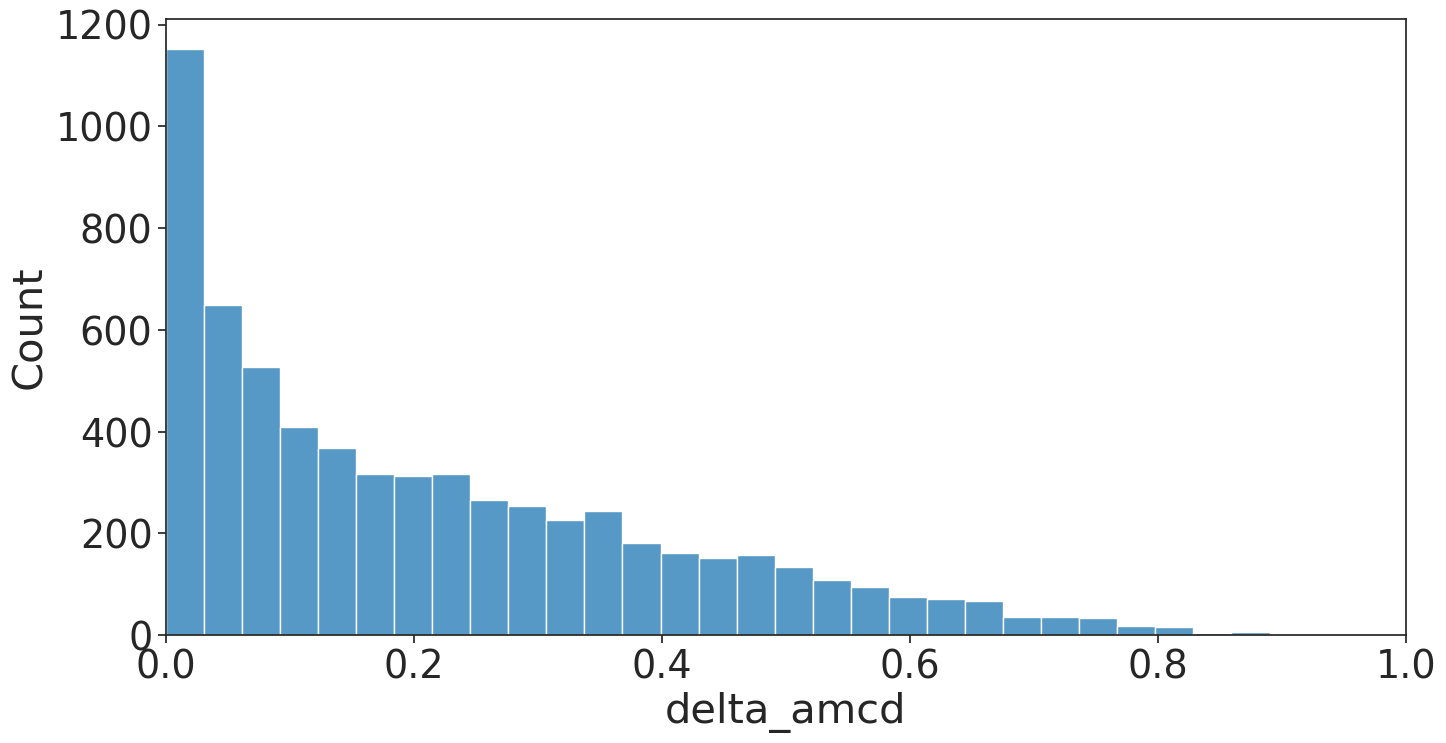

In [58]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.histplot(x='delta_amcd',data=df_pairs, color='#1f77b4')
ax.set_xlim(0, 1)
plt.legend([],[], frameon=False)
plt.savefig('plots/FDA_delta_amcd.png', bbox_inches='tight', dpi=600)

Extract the distances of selected pairs in a new dataframe for comparison in violin and scatter plots

In [59]:
df_dist_selected = df_pairs[['ecfp4_dist', 'ecfp6_dist', 'mhfp6_dist', 'ap_dist', 'mxfp_dist', 'map4_dist', 'maccs_dist', 'mqn_dist', 'amcd']]
df_dist_selected.columns = ['ecfp4', 'ecfp6', 'mhfp6', 'ap', 'mxfp', 'map4', 'maccs', 'mqn', 'amcd']

df_dist_selected = df_dist_selected.stack().reset_index()
df_dist_selected.columns = ['index', 'fingerprint', 'distance']

#### Analysis of all pairs and selected pairs

Violin plots comparing distributions of distances for all pairs vs. selected pairs. Additionally, the distribution of confidence for selected pairs only is shown.

In [60]:
df_dist['set'] = 'all pairs'
df_dist_selected['set'] = 'selected pairs'
df_violin = pd.concat([df_dist, df_dist_selected], ignore_index=True, axis=0)

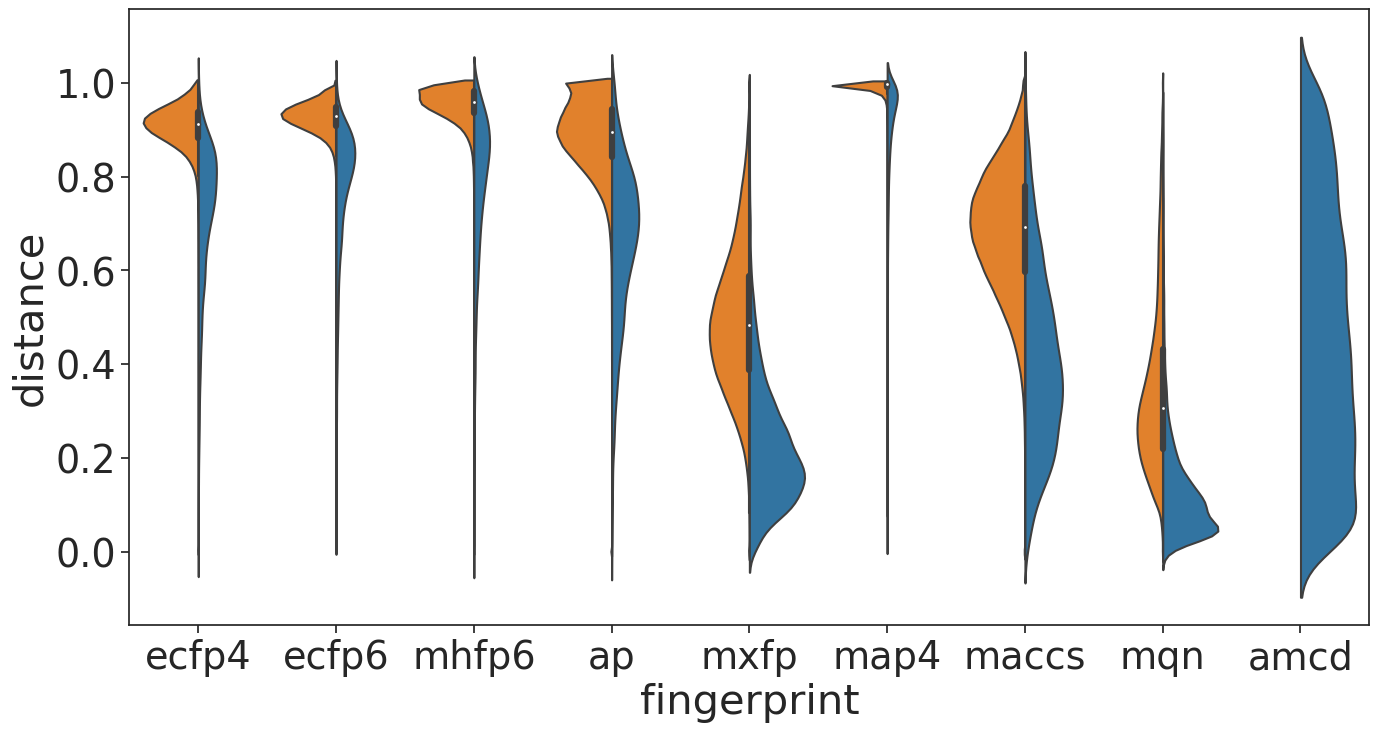

In [61]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.violinplot(x='fingerprint', y='distance', hue='set', data=df_violin, ax=ax, split=True, scale_hue=True, palette=['#ff7f0e', '#1f77b4'], legend=False)
plt.legend([],[], frameon=False)
plt.savefig('plots/FDA_violin_plots.png', bbox_inches='tight', dpi=600)

Scatter plots comparing pairwise distances of selected pairs

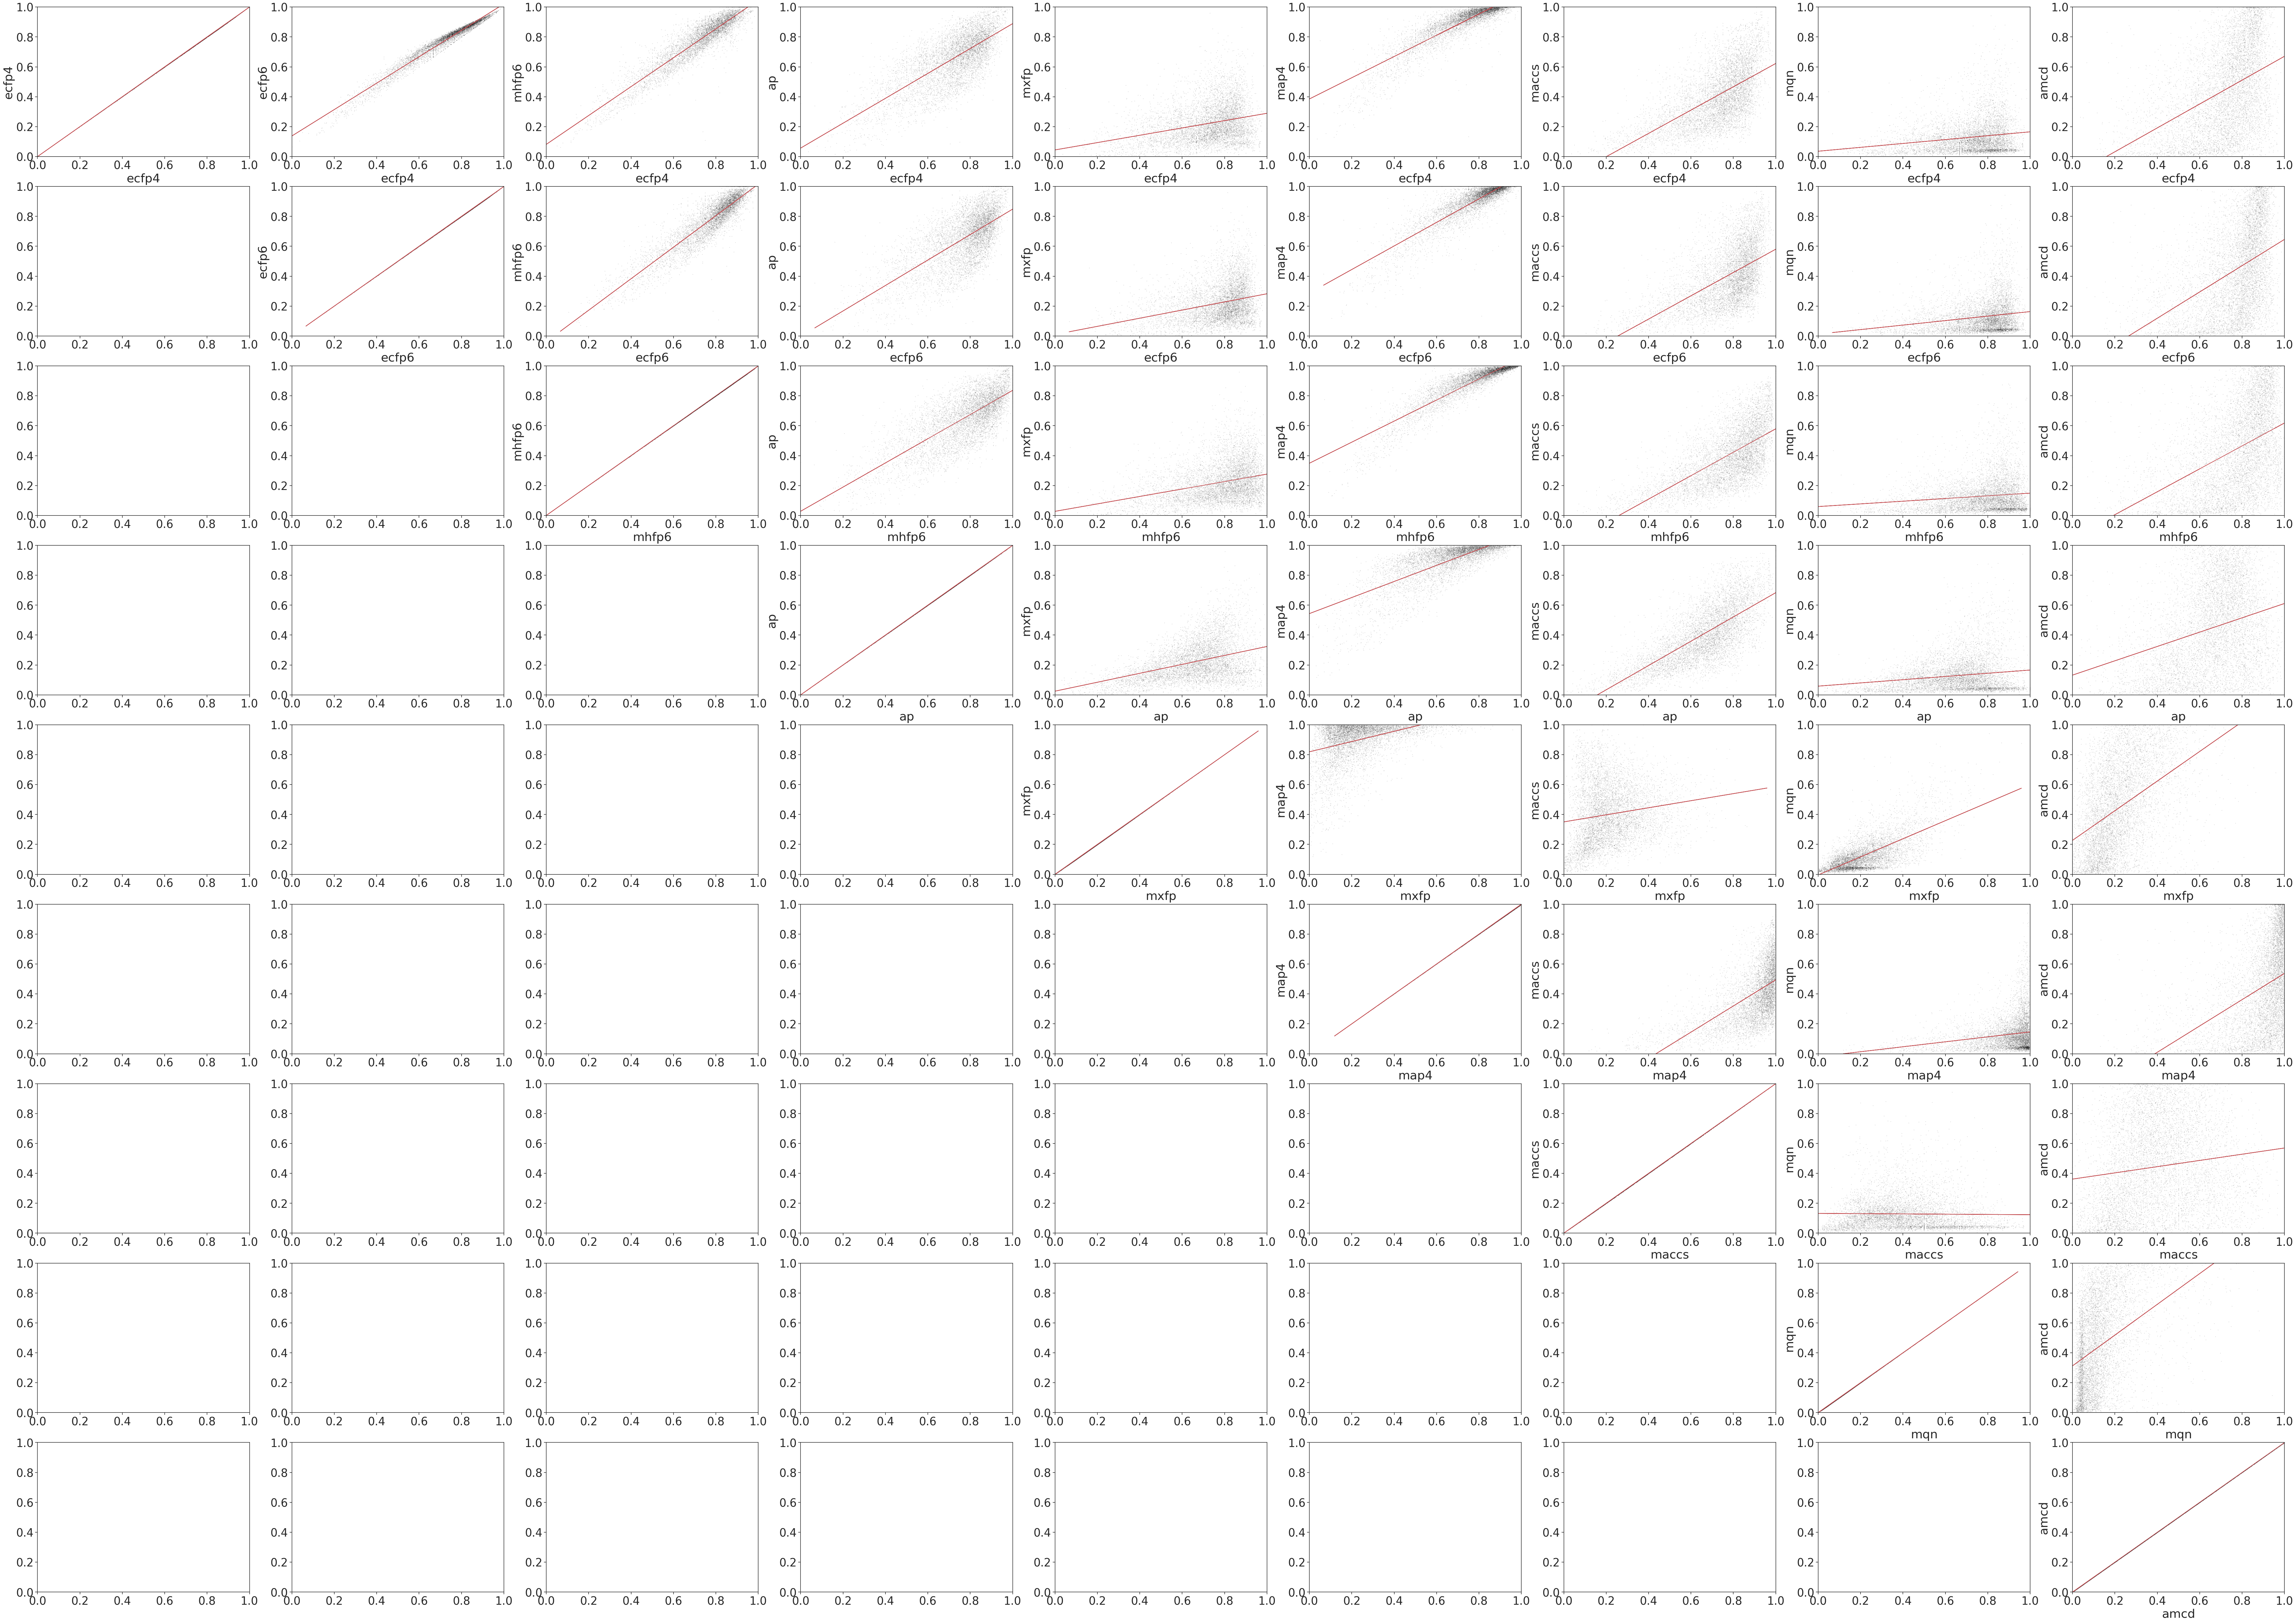

In [62]:
distance_list = [df_pairs['ecfp4_dist'].values, df_pairs['ecfp6_dist'].values, df_pairs['mhfp6_dist'].values, df_pairs['ap_dist'].values, df_pairs['mxfp_dist'].values, df_pairs['map4_dist'].values, df_pairs['maccs_dist'].values, df_pairs['mqn_dist'].values, df_pairs['amcd'].values]
fingerprint_names = ['ecfp4', 'ecfp6', 'mhfp6', 'ap', 'mxfp', 'map4', 'maccs', 'mqn', 'amcd']
r2 = np.zeros((9, 9))

fig, axs = plt.subplots(9, 9, figsize=(100, 71))
axs = axs.flatten()
for i in range(len(distance_list)):
    for j in range(i, len(distance_list)):
        ax = axs[i * 9 + j]
        ax.scatter(distance_list[i], distance_list[j], s=1, alpha=0.1, color='k')
        slope, intercept, r_value, p_value, std_err = stats.linregress(distance_list[i], distance_list[j])
        r2[i, j] = r_value ** 2
        r2[j, i] = r_value ** 2
        ax.plot(distance_list[i], intercept + slope * distance_list[i], 'r')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel(fingerprint_names[i])
        ax.set_ylabel(fingerprint_names[j])

Heatmap of r^2 values

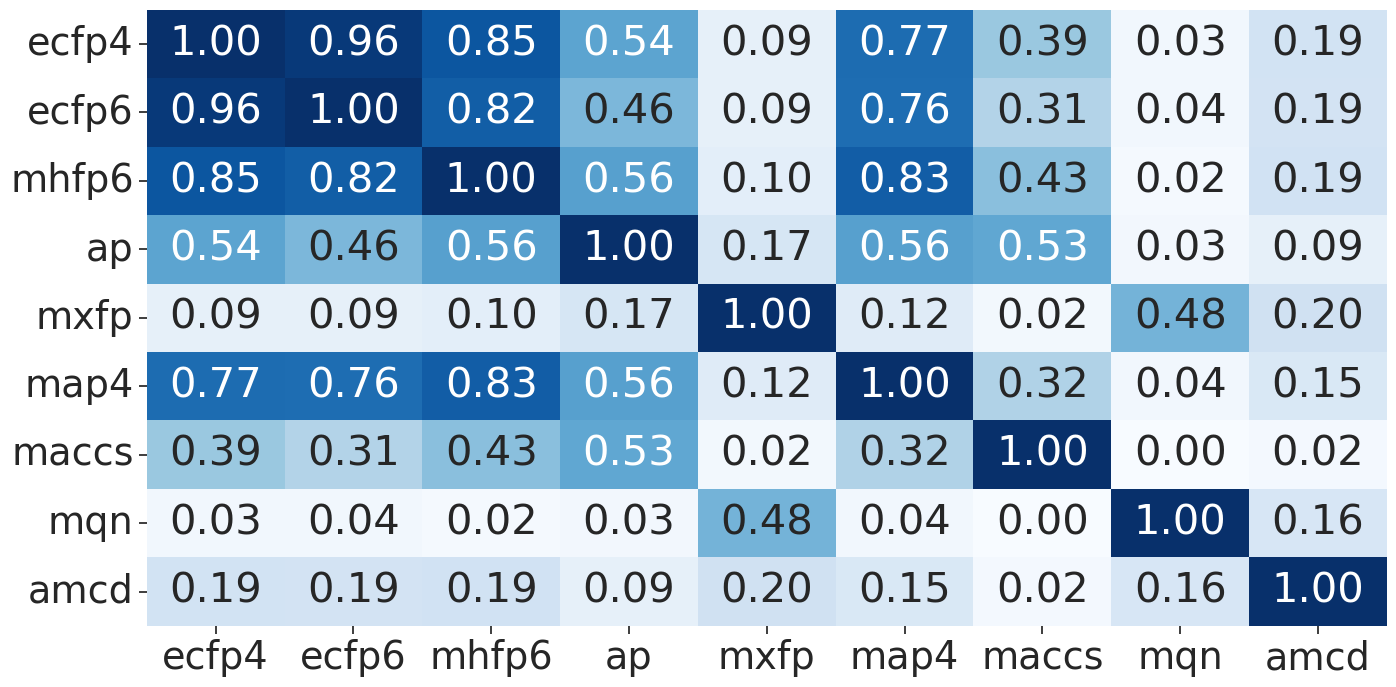

In [63]:
fig, ax = plt.subplots(figsize=(16, 8))
ax = sns.heatmap(r2, annot=True, fmt='.2f', cmap='Blues', cbar=False)
ax.set_xticklabels(['ecfp4', 'ecfp6', 'mhfp6', 'ap', 'mxfp', 'map4', 'maccs', 'mqn', 'amcd'])
ax.set_yticklabels(['ecfp4', 'ecfp6', 'mhfp6', 'ap', 'mxfp', 'map4', 'maccs', 'mqn', 'amcd'], rotation=0)
plt.savefig('plots/FDA_r2_heatmap_selected.png', bbox_inches='tight', dpi=600)

Barplot of drug occurrences in the selected pairs

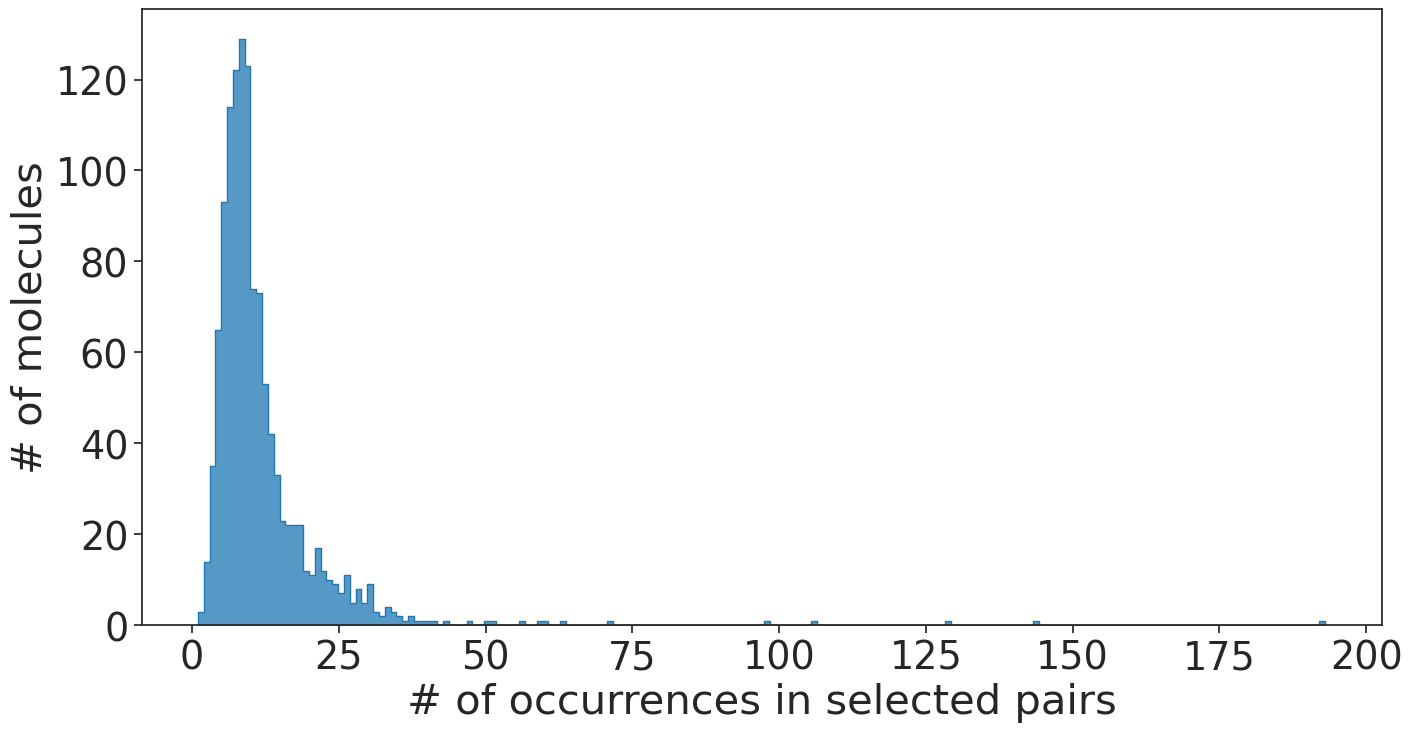

In [64]:
def substring_count(substring, string_list):
    count = 0
    for string in string_list:
        if substring in string:
            count += 1
    return count

df['count_in_selected_pairs'] = df['isomeric_smiles'].apply(lambda x: substring_count(x, df_pairs['reaction_smiles'].values))

fig, ax = plt.subplots(figsize=(16, 8))
sns.histplot(x='count_in_selected_pairs', data=df, color='#1f77b4', bins=max(df['count_in_selected_pairs'].values), element='step')
ax.set_xlabel('# of occurrences in selected pairs')
ax.set_ylabel('# of molecules')
plt.legend([],[], frameon=False)
plt.savefig('plots/FDA_barplot.png', bbox_inches='tight', dpi=600)

Add mean occurrences to selected pairs data frame

In [65]:
def mean_occurrence_in_selected_pairs(reaction_smiles, df):
    reactants = reaction_smiles.split('>>')
    occurrences = []
    for reactant in reactants:
        occurrences.append(df[df['isomeric_smiles'] == reactant]['count_in_selected_pairs'].values[0])
    return log10(np.mean(occurrences))

df_pairs['mean_occurrence'] = df_pairs['reaction_smiles'].apply(lambda x: mean_occurrence_in_selected_pairs(x, df))

#### Plot selected pairs with TMAP

Label selected pairs

In [66]:
def FindSelections(smiles):
    if smiles == 'COC1=CC2=C(C3=CC=C(OC)C(=O)C=C3[C@@H](NC(C)=O)CC2)C(OC)=C1OC>>COC1=CC([C@@H]2C3=CC4=C(C=C3[C@H](O)[C@H]3COC(=O)[C@H]23)OCO4)=CC(OC)=C1OC':
        return '1 - Podophyllotoxin >> Colchicine'
    elif smiles == 'CCCN(CCC)CCC1=CC=CC2=C1CC(=O)N2>>CCCN(CCC1=CC=CS1)[C@@H]1CCC2=C(O)C=CC=C2C1':
        return '2 - Ropinirole >> Rotigotine'
    elif smiles == 'CN(C)C/C=C/C(=O)NC1=CC2=C(NC3=CC=C(F)C(Cl)=C3)N=CN=C2C=C1O[C@H]1CCOC1>>C=CC(=O)NC1=CC(NC2=NC=CC(C3=CN(C)C4=CC=CC=C34)=N2)=C(OC)C=C1N(C)CCN(C)C':
        return '3 - Afatinib >> Osimertinib'
    elif smiles == 'O=C1CCC2=CC=C(OCCCCN3CCN(C4=CC=CC(Cl)=C4Cl)CC3)C=C2N1>>N#CC1=CC=C2NC=C(CCCCN3CCN(C4=CC=C5OC(C(N)=O)=CC5=C4)CC3)C2=C1':
        return '4 - Vilazodone >> Aripiprazole'
    elif smiles == 'COC1=CC=C2C[C@@H]3[C@@H]4CCC(=O)[C@@H]5OC1=C2[C@@]54CCN3C>>COC1=CC2=C(C=C1OC)[C@@H]1CC(=O)[C@H](CC(C)C)CN1CC2':
        return '5 - Hydrocodone >> (-)-Tetrabenazine)'
    elif smiles in ['NC(=O)C1=CC=CN=C1>>COC(=O)C1=CC=CN=C1', 'N[C@@H](CC1=CC=C(O)C=C1)C(=O)O>>N[C@@H](CC1=CC=C(O)C(O)=C1)C(=O)O', 'CN1CC[C@]23C4=C5C=CC(O)=C4O[C@H]2C(=O)CC[C@H]3[C@H]1C5>>CN1CC[C@]23C4=C5C=CC(O)=C4O[C@H]2C(=O)CC[C@@]3(O)[C@H]1C5']:
        return '6 - Real reaction'
    else:
        return 'Not selected'

df_pairs['selection'] = df_pairs['reaction_smiles'].apply(lambda x: FindSelections(x))
df_pairs = df_pairs.sort_values(by=['selection'], ascending=False)

Calculate DRFP

In [67]:
df_pairs['drfp'] = DrfpEncoder.encode(df_pairs['reaction_smiles'].values)

Determine nearest neighbours in the DRFP feature space and use the nearest neighbours to prepare the TMAP layout

In [68]:
drfps = df_pairs['drfp'].values.tolist()

knn = 20
knn_search = NearestNeighbors(n_neighbors=knn, radius=1.0, algorithm='auto', leaf_size=30, metric='jaccard', p=2, metric_params=None, n_jobs=None)
knn_search.fit(np.array(drfps))

edge_list = []
for i in tqdm(range(len(drfps))):
    dists, idxs = knn_search.kneighbors(drfps[i].reshape(1, -1))
    for j in range(knn):
        edge_list.append([i, idxs[0, j], dists[0, j]])

100%|██████████| 6404/6404 [00:31<00:00, 201.59it/s]


Prepare TMAP layout

In [69]:
if not os.path.exists('pickles/FDA_tmap_layout.pkl'):
    cfg = tm.LayoutConfiguration()
    cfg.node_size = 1 / 30
    cfg.mmm_repeats = 2
    cfg.sl_extra_scaling_steps = 5
    cfg.k = 20
    cfg.sl_scaling_type = tm.RelativeToAvgLength

    x_, y_, s, t, gp = tm.layout_from_edge_list(len(drfps), edge_list, cfg)
    tm_layout_drfp = {'x': list(x_), 'y': list(y_), 's': list(s), 't': list(t)}
    joblib.dump(tm_layout_drfp, 'pickles/FDA_tmap_layout.pkl')
else:
    tm_layout_drfp = joblib.load('pickles/FDA_tmap_layout.pkl')

Create Faerun categories for categorical data. Prepare colormaps for the categorical data

In [70]:
cividis_3 = cm.get_cmap('cividis', 3)
cividis_7 = cm.get_cmap('turbo_r', 7)
cividis_8 = cm.get_cmap('cividis', 8)

consensus_labels, consensus_data = Faerun.create_categories(df_pairs['count'])
selected_labels, selected_data = Faerun.create_categories(df_pairs['selection'])
origin_labels, origin_data = Faerun.create_categories(df_pairs['origin'])

Prepare labels

In [71]:
labels = []
for i, row in df_pairs.iterrows():
    labels.append(
            row["reaction_smiles"]
            + "__"
            + row['reaction_smiles']
            + f"__{row['origin']}"
        )

Plot pairs

In [72]:
f = Faerun(
    view="front", 
    coords=False,
    title="",
    clear_color='#FFFFFF',
)

f.add_scatter(
    "DRFP_TMAP",
    {
        "x": tm.VectorFloat(tm_layout_drfp['x']),
        "y": tm.VectorFloat(tm_layout_drfp['y'] ),
        "c": [
            consensus_data,
            selected_data,
            origin_data,
            df_pairs['amcd'].values.tolist(),
            df_pairs['mean_occurrence'].values.tolist(),
            df_pairs['mu_molecular_weight'].values.tolist(),
            df_pairs['mu_fraction_csp3'].values.tolist(),
            df_pairs['mu_fraction_c'].values.tolist(),
            df_pairs['mu_fraction_n'].values.tolist(),
            df_pairs['mu_fraction_o'].values.tolist(),
            df_pairs['mu_fraction_s'].values.tolist(),
            df_pairs['mu_fraction_halogen'].values.tolist(),
            df_pairs['mu_fraction_hba'].values.tolist(),
            df_pairs['mu_fraction_hbd'].values.tolist(),
            df_pairs['mu_ring_count'].values.tolist(),
            df_pairs['mu_clogp'].values.tolist(),
            df_pairs['mxfp_dist'].values.tolist(),
            df_pairs['ap_dist'].values.tolist(),
            df_pairs['map4_dist'].values.tolist(),
            df_pairs['mhfp6_dist'].values.tolist(),
            df_pairs['ecfp4_dist'].values.tolist(),
            df_pairs['ecfp6_dist'].values.tolist(),
            df_pairs['maccs_dist'].values.tolist(),
            df_pairs['mqn_dist'].values.tolist(),
            ], 
        "labels": labels,
    },
    shader="smoothCircle",
    point_scale=7,
    max_point_size=20,
    selected_labels=['Reaction SMILES', 'Reaction SMILES', 'Origin'],
    legend_labels=[consensus_labels, selected_labels, origin_labels, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],
    categorical=[True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False],
    colormap=[cividis_8, cividis_7, cividis_3, 'cividis', 'cividis', 'cividis', 'cividis', 'cividis', 'cividis', 'cividis', 'cividis', 'cividis', 'cividis', 'cividis', 'cividis', 'cividis', 'cividis', 'cividis', 'cividis', 'cividis', 'cividis', 'cividis', 'cividis'],
    series_title=['consensus score', 'selected pairs', 'origin', 'mean amcd', 'log mean occurrence', 'mean molecular weight', 'mean fraction csp3', 'mean fraction c', 'mean fraction n', 'mean fraction o', 'mean fraction s', 'mean fraction halogen', 'mean fraction hba', 'mean fraction hbd', 'mean ring count', 'mean clogp', 'mxfp distance', 'ap distance', 'map4 distance', 'mhfp6 distance', 'ecfp4 distance', 'ecfp6 distance', 'maccs distance', 'mqn distance'],
    has_legend=True,
)
f.add_tree("DRFP_TMAP_tree", {"from": tm.VectorUint(tm_layout_drfp['s']), "to": tm.VectorUint(tm_layout_drfp['t'])}, point_helper="DRFP_TMAP")
f.plot('plots/FDA_DRFP_TMAP', template='smiles')

/home/markus/Developer/Code/MolecularPairs/plots/FDA_DRFP_TMAP.html